<a href="https://colab.research.google.com/github/Nekose/Antibody_Analysis/blob/main/antibody_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install PyPDF2
import pandas as pd
import seaborn as sns
import numpy as np
%matplotlib inline
from itertools import zip_longest
import PyPDF2
import os

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def convert_longform(csv):
    rawtable = []
    for row in open(csv):
        rawtable.append(row.split("\t"))
        longform = []
        for line in rawtable:
            sampleID = line[1]
            CO = int(line[47])
            max = int(line[53])
            results = line[6:42]
            for pos,item in enumerate(results):
                if pos == 1:
                    continue
                elif pos % 2 == 0:
                    continue
                if item[-1] == "*":
                    item = item[0:-1]
                elif item == '>max':
                    item = max
                if int(item) > max:
                    longform.append([sampleID,results[pos-1],max,CO,max,"Positive"])
                else:
                    result = "Negative"
                    if int(item)>CO:
                        result = "Positive"
                    longform.append([sampleID,results[pos-1],int(item),CO,max,result])
    return longform

def create_fig(df,columns,figheight,figaspect,name):
    g = sns.FacetGrid(df, col="SampleID",hue="Result",col_wrap=columns, height=figheight, aspect=figaspect,sharex=False,sharey=False)
    g.map(sns.barplot,"Value","Antibody",order=["Mi-2","Ku","U1-snRNP","CENP-B","Nucleosome","Histone","dsDNA","Jo-1","Scl-70","Sm","P0","PCNA","La/SS-B","Ro/SS-A 52","Ro/SS-A 60","AMA-M2","PM/Scl-100"])

    cutoffs = df["Pos_Cutoff"][::17]
    maxes = df["Max"][::17]
    #g.fig.tight_layout()
    for axes,co,maxscale in zip(g.axes,cutoffs,maxes):
        axes.grid(b=True)
        axes.axvline(co,ls='--',color="blue")
        axes.axvline(maxscale,color="red")
        #axes.set_xbound(None,df["Value"].max()+10)
    g.savefig(f'{name}.pdf')

def split_dataframe(df,number_of_samples):
    returnlist = []
    current_step = 0
    for next_step in range(0,(len(df))+1,17*number_of_samples):
        subdata = df.iloc[current_step:next_step]
        current_step = next_step
        returnlist.append(subdata)
    return returnlist[1:]

In [ ]:
df = pd.DataFrame(convert_longform("export.csv"),columns = ['SampleID',"Antibody","Value","Pos_Cutoff","Max","Result"])

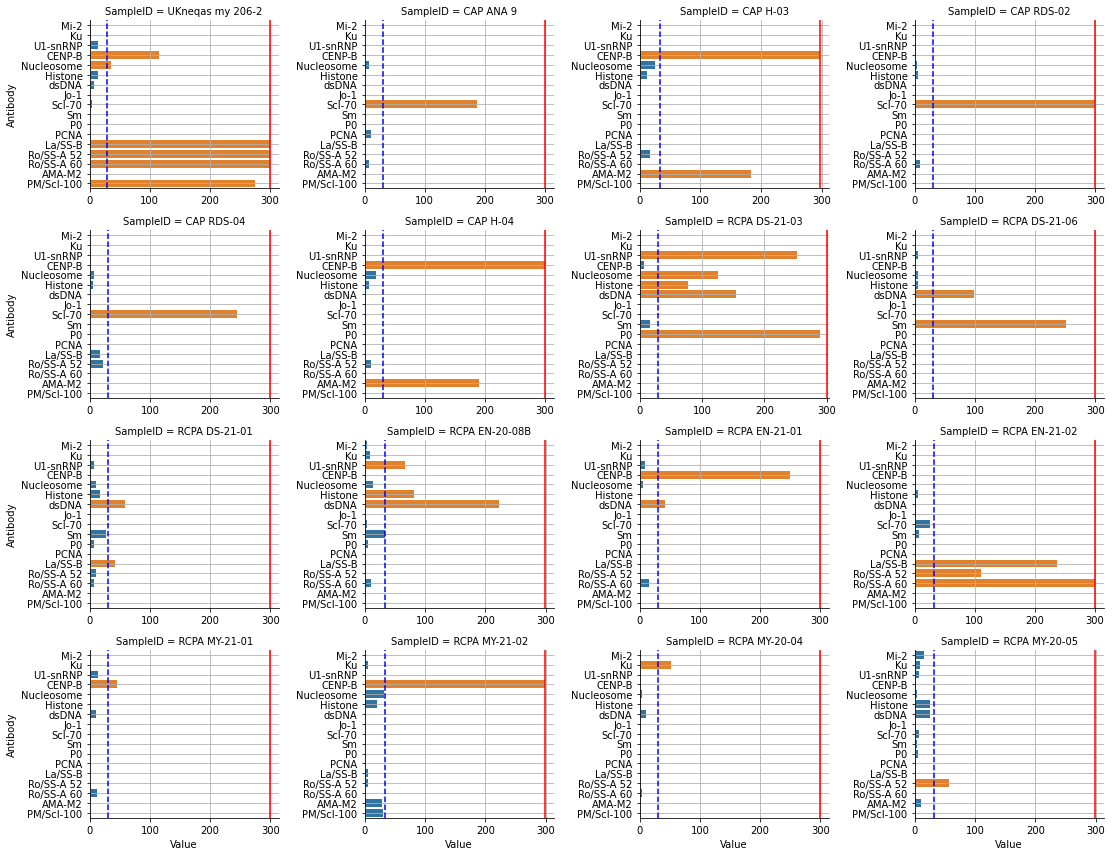

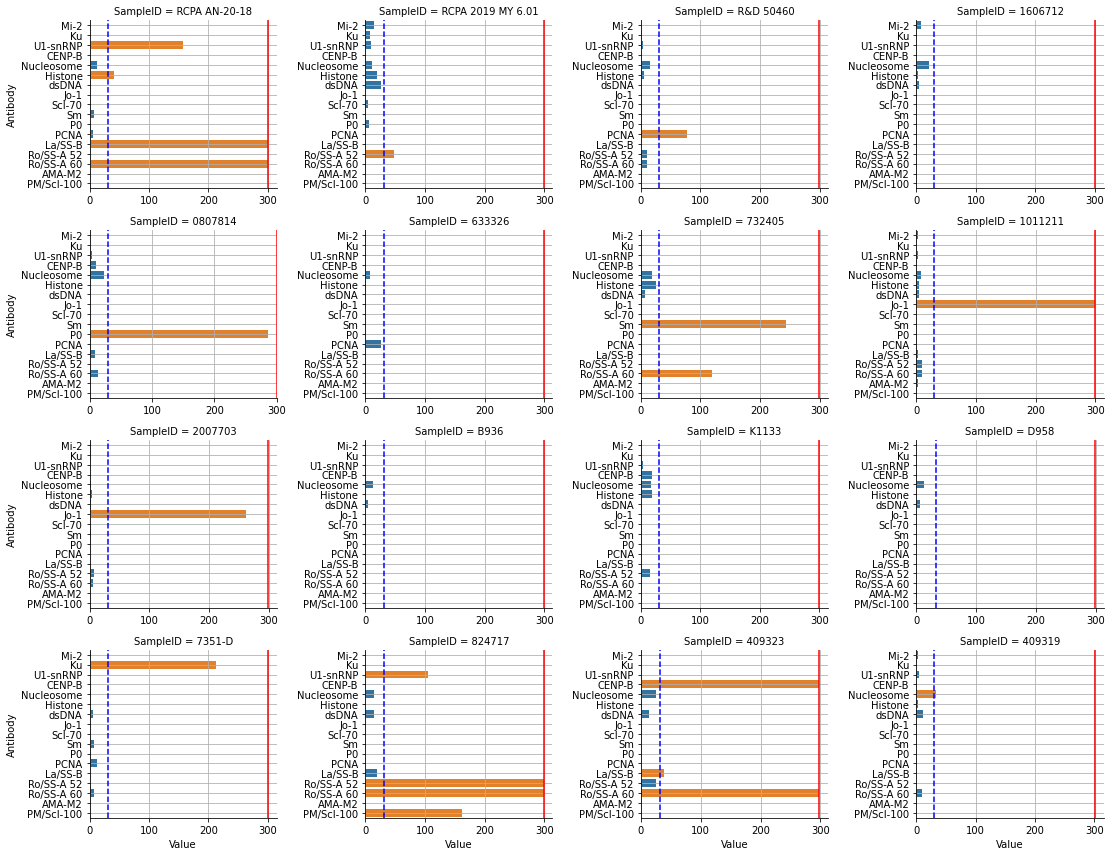

In [ ]:
dataframes = split_dataframe(df,16)
for pos,element in enumerate(dataframes):
    create_fig(element,4,3,11/8.5,f'page_{str(pos)}_temp')

In [ ]:
import os
merger = PyPDF2.PdfFileMerger()
filelist = [x for x in os.listdir(os.getcwd()) if x.endswith("temp.pdf")]
for file in filelist:
    merger.append(file)
merger.write("Output.pdf")
